#### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

tf.config.list_physical_devices('gpu')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

%matplotlib inline


2024-08-09 06:25:40.203986: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-09 06:25:40.229590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 06:25:40.229615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 06:25:40.230524: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-09 06:25:40.235363: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-08-09 06:25:41.525872: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 06:25:41.548491: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 06:25:41.548632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Set Path Variable

In [2]:
main_directory = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest4'

class_labels = ['normal', 'slowing-wave', 'spike-and-wave']
class_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder

dest_list = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder
waveletsTypes = ['mexh','morl', 'gaus1', 'gaus2']
splits = ['train', 'valid', 'test']
# import cv2
# def crop_img(image):
#     height, width = image.shape[:2]
#     crop_height = height - 20  # Crop 10 pixels from top and bottom
#     crop_width = width - 20    # Crop 10 pixels from left and right

#     cropped_image = image[10:10+crop_height, 10:10+crop_width, :]
#     cropped_image = cv2.resize(cropped_image,(224,224))
#     return cropped_image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)


#### Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def plotImages(images_arr,train_labels):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(train_labels[i])
        i = i+1
    plt.tight_layout()
    plt.show()

# Model Implementation

### Prepare Callbacks

In [5]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

os.chdir(main_directory)

## Google LeNEt

In [6]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    tf.keras.backend.clear_session()
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model



## Vgg16

In [7]:
def plot_accuracy_loss(loss,val_loss,accuracy,val_accuracy):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
def test_model(model,test_batches,model_type):

    y_test=test_batches.classes

    model.evaluate(test_batches)

    predictions = model.predict(test_batches, verbose = 2)

    if model_type == "googlenet":
        y_pred = np.argmax(predictions[1], axis = 1)
    else:
        y_pred = np.argmax(predictions, axis = 1)    

    cm = confusion_matrix(y_test, y_pred)

    cm_plot_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

    print(accuracy_score(y_test, y_pred))

    target_names = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

In [9]:
def evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath, class_weights):

    mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

    ###### Train Model
    history = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

    google_lenet.save(checkpoint_filepath+'/googlenet/GoogLenet_-final3.h5')
    google_lenet.save_weights(checkpoint_filepath+'/googlenet/GoogLenet_-final3.tf', save_format='tf')

    ###### Model Plots
    plot_accuracy_loss(history.history['dense_4_loss'],history.history['val_dense_4_loss'],history.history['dense_4_accuracy'],history.history['val_dense_4_accuracy'])

    return google_lenet


In [10]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = vgg16_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    vgg16_model_custom.save(checkpoint_filepath+'/vgg16/VGG16_baseline3.h5')
    vgg16_model_custom.save_weights(checkpoint_filepath+'/vgg16/VGG16_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return vgg16_model_custom

In [11]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_effNet(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = effNet_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    effNet_model_custom.save(checkpoint_filepath+'/vgg16/effNet_baseline3.h5')
    effNet_model_custom.save_weights(checkpoint_filepath+'/vgg16/effNet_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return effNet_model_custom

------------------- mexh -------------------------


Found 307013 images belonging to 3 classes.
Found 53451 images belonging to 3 classes.
Found 87049 images belonging to 3 classes.
Class Weights {0: 0.6870005750868784, 1: 1.0776356201407535, 2: 1.6222186996380545}


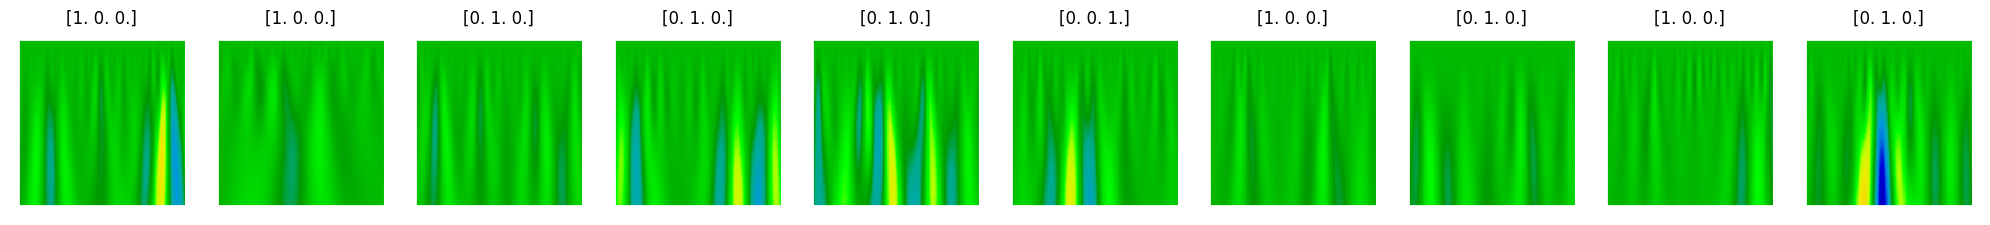

2024-08-09 06:25:44.282324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 06:25:44.282484: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-09 06:25:44.282545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-09 06:25:58.462423: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-09 06:26:00.297797: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-08-09 06:26:00.938610: I external/local_xla/xla/service/service.cc:168] XLA service 0x71d8a53e15b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-09 06:26:00.938636: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-08-09 06:26:00.942517: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723166761.000179 2159580 device_compiler.h:186] Compiled cluster

9595/9595 [==============================] - 1226s 125ms/step - loss: 0.8645 - accuracy: 0.6887 - val_loss: 0.5392 - val_accuracy: 0.7848
Epoch 2/30
9595/9595 [==============================] - 1141s 119ms/step - loss: 0.4945 - accuracy: 0.8066 - val_loss: 0.4399 - val_accuracy: 0.8286
Epoch 3/30
9595/9595 [==============================] - 1142s 119ms/step - loss: 0.4076 - accuracy: 0.8422 - val_loss: 0.3815 - val_accuracy: 0.8519
Epoch 4/30
9595/9595 [==============================] - 1143s 119ms/step - loss: 0.3620 - accuracy: 0.8598 - val_loss: 0.3428 - val_accuracy: 0.8643
Epoch 5/30
9595/9595 [==============================] - 1141s 119ms/step - loss: 0.3298 - accuracy: 0.8717 - val_loss: 0.3236 - val_accuracy: 0.8733
Epoch 6/30
9595/9595 [==============================] - 1141s 119ms/step - loss: 0.3024 - accuracy: 0.8830 - val_loss: 0.3547 - val_accuracy: 0.8685
Epoch 7/30
9595/9595 [==============================] - 1141s 119ms/step - loss: 0.2763 - accuracy: 0.8936 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


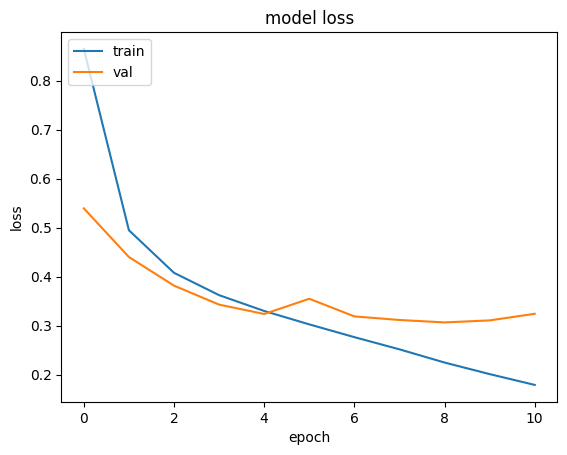

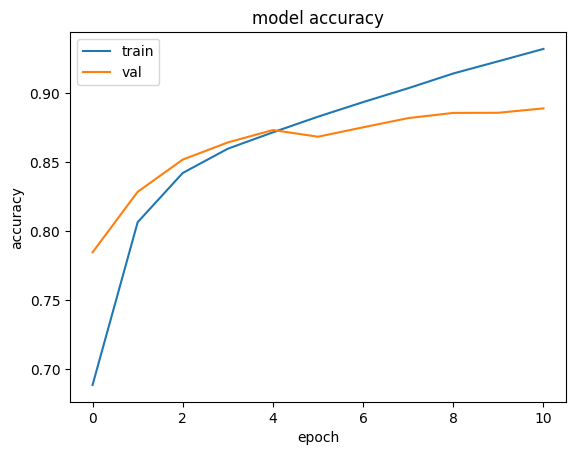

5441/5441 [==============================] - 86s 16ms/step - loss: 0.8527 - accuracy: 0.7458
5441/5441 - 75s - 75s/epoch - 14ms/step
Confusion matrix, without normalization
[[37317  2536  2019]
 [ 2347 16865  3594]
 [ 5415  6214 10742]]


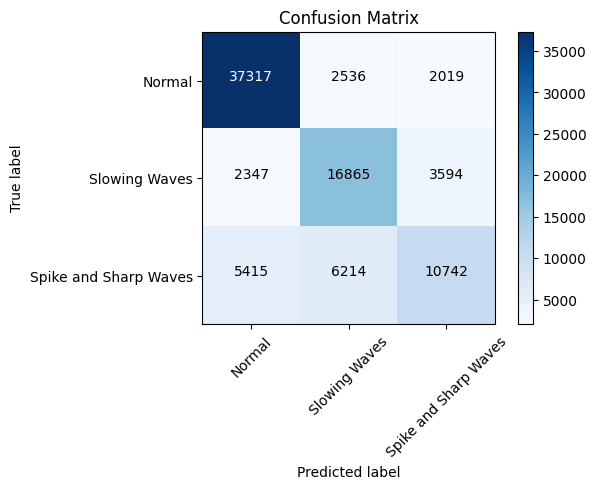

0.7458328068099576
                       precision    recall  f1-score   support

               Normal    0.82781   0.89122   0.85835     41872
        Slowing Waves    0.65840   0.73950   0.69660     22806
Spike and Sharp Waves    0.65680   0.48018   0.55477     22371

             accuracy                        0.74583     87049
            macro avg    0.71434   0.70363   0.70324     87049
         weighted avg    0.73948   0.74583   0.73795     87049

Epoch 1/30
9595/9595 [==============================] - 327s 33ms/step - loss: 1.6053 - dense_4_loss: 0.5183 - dense_1_loss: 0.5608 - dense_3_loss: 0.5261 - dense_4_accuracy: 0.7868 - dense_1_accuracy: 0.7651 - dense_3_accuracy: 0.7836 - val_loss: 1.3242 - val_dense_4_loss: 0.4295 - val_dense_1_loss: 0.4626 - val_dense_3_loss: 0.4322 - val_dense_4_accuracy: 0.8307 - val_dense_1_accuracy: 0.8174 - val_dense_3_accuracy: 0.8300
Epoch 2/30
9595/9595 [==============================] - 308s 32ms/step - loss: 1.3081 - dense_4_loss: 0.4205

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


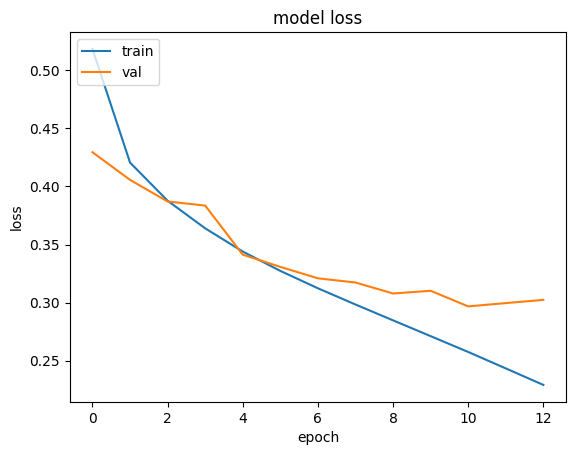

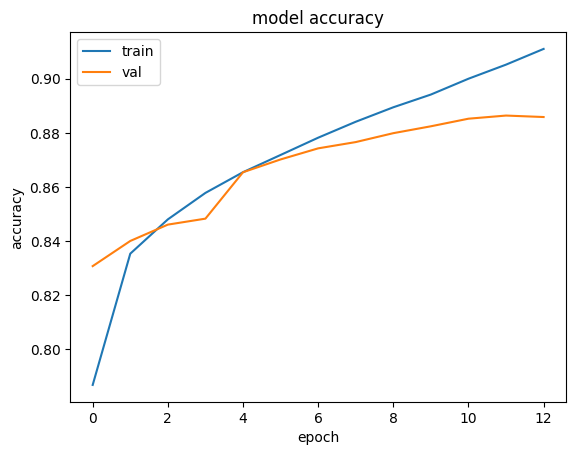

5441/5441 [==============================] - 56s 10ms/step - loss: 1.7130 - dense_4_loss: 0.6051 - dense_1_loss: 0.5540 - dense_3_loss: 0.5538 - dense_4_accuracy: 0.7853 - dense_1_accuracy: 0.7835 - dense_3_accuracy: 0.7907
5441/5441 - 54s - 54s/epoch - 10ms/step
Confusion matrix, without normalization
[[37488  2081  2303]
 [ 1723 17058  4025]
 [ 4026  4690 13655]]


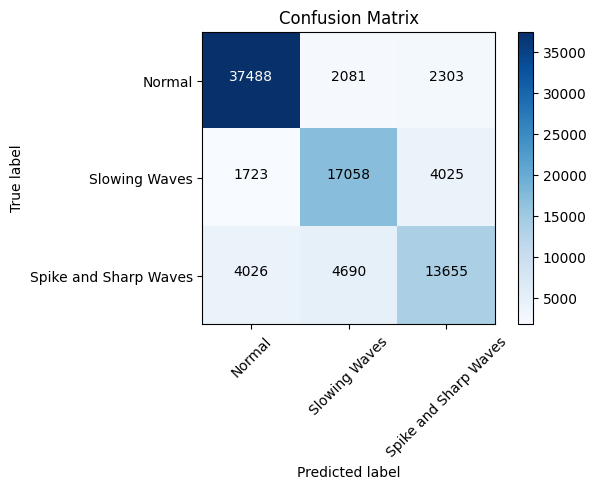

0.7834782708589415
                       precision    recall  f1-score   support

               Normal    0.86704   0.89530   0.88094     41872
        Slowing Waves    0.71585   0.74796   0.73155     22806
Spike and Sharp Waves    0.68333   0.61039   0.64480     22371

             accuracy                        0.78348     87049
            macro avg    0.75541   0.75122   0.75243     87049
         weighted avg    0.78022   0.78348   0.78112     87049

Epoch 1/30
9595/9595 [==============================] - 1131s 117ms/step - loss: 0.4471 - accuracy: 0.8231 - val_loss: 0.3910 - val_accuracy: 0.8453
Epoch 2/30
9595/9595 [==============================] - 1109s 116ms/step - loss: 0.3649 - accuracy: 0.8574 - val_loss: 0.3528 - val_accuracy: 0.8614
Epoch 3/30
9595/9595 [==============================] - 1107s 115ms/step - loss: 0.3320 - accuracy: 0.8713 - val_loss: 0.3431 - val_accuracy: 0.8666
Epoch 4/30
9595/9595 [==============================] - 1107s 115ms/step - loss: 0.3048 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


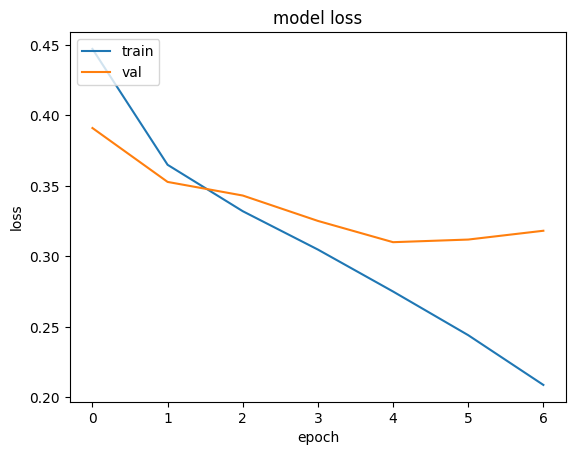

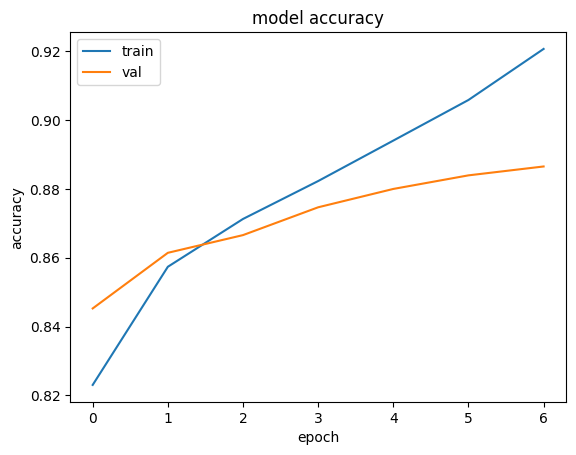

5441/5441 [==============================] - 148s 27ms/step - loss: 0.7466 - accuracy: 0.7500
5441/5441 - 162s - 162s/epoch - 30ms/step
Confusion matrix, without normalization
[[37222  2843  1807]
 [ 2928 16587  3291]
 [ 4678  6219 11474]]


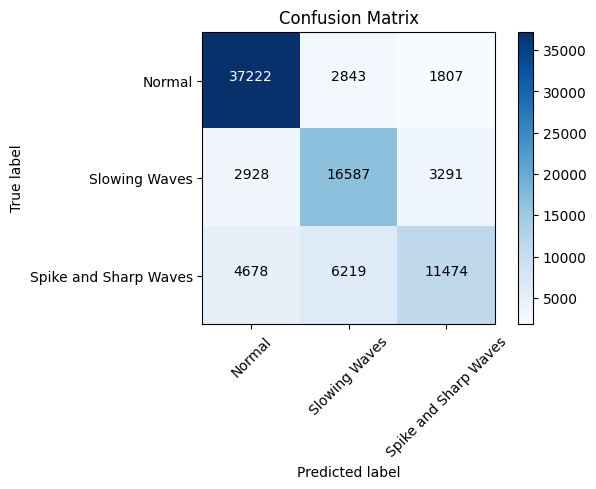

0.7499569208147135
                       precision    recall  f1-score   support

               Normal    0.83033   0.88895   0.85864     41872
        Slowing Waves    0.64669   0.72731   0.68464     22806
Spike and Sharp Waves    0.69237   0.51290   0.58927     22371

             accuracy                        0.74996     87049
            macro avg    0.72313   0.70972   0.71085     87049
         weighted avg    0.74676   0.74996   0.74383     87049

------------------- morl -------------------------
Found 307067 images belonging to 3 classes.
Found 53423 images belonging to 3 classes.
Found 87081 images belonging to 3 classes.
Class Weights {0: 0.6868724150041047, 1: 1.077825163656786, 2: 1.6225040289556418}


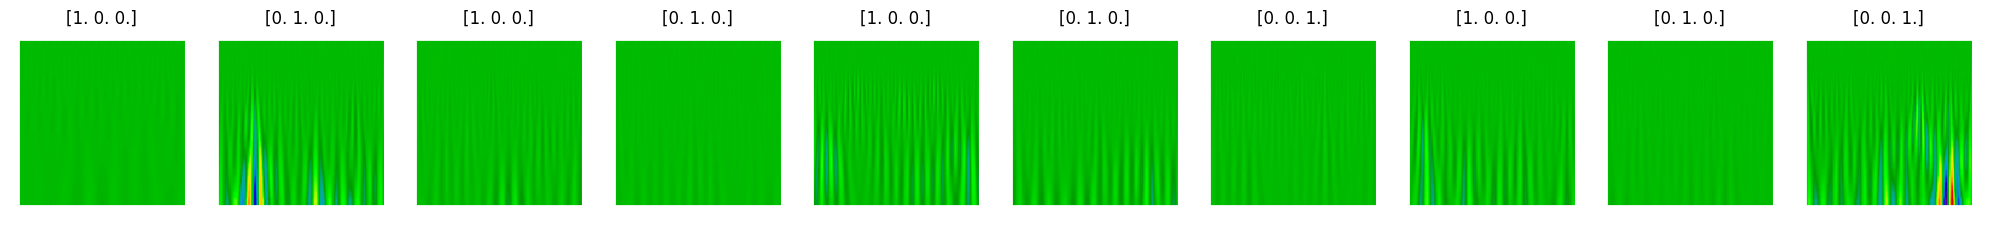

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-09 13:25:55.024346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9596/9596 [==============================] - 1462s 147ms/step - loss: 0.9754 - accuracy: 0.6151 - val_loss: 0.6375 - val_accuracy: 0.7334
Epoch 2/30
9596/9596 [==============================] - 1367s 142ms/step - loss: 0.5895 - accuracy: 0.7577 - val_loss: 0.5606 - val_accuracy: 0.7660
Epoch 3/30
9596/9596 [==============================] - 1342s 140ms/step - loss: 0.4797 - accuracy: 0.8073 - val_loss: 0.4404 - val_accuracy: 0.8245
Epoch 4/30
9596/9596 [==============================] - 1341s 140ms/step - loss: 0.4295 - accuracy: 0.8293 - val_loss: 0.4755 - val_accuracy: 0.8084
Epoch 5/30
9596/9596 [==============================] - 1343s 140ms/step - loss: 0.3917 - accuracy: 0.8449 - val_loss: 0.4048 - val_accuracy: 0.8388
Epoch 6/30
9596/9596 [==============================] - 1332s 139ms/step - loss: 0.3614 - accuracy: 0.8579 - val_loss: 0.3658 - val_accuracy: 0.8566
Epoch 7/30
9596/9596 [==============================] - 1338s 139ms/step - loss: 0.3341 - accuracy: 0.8687 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


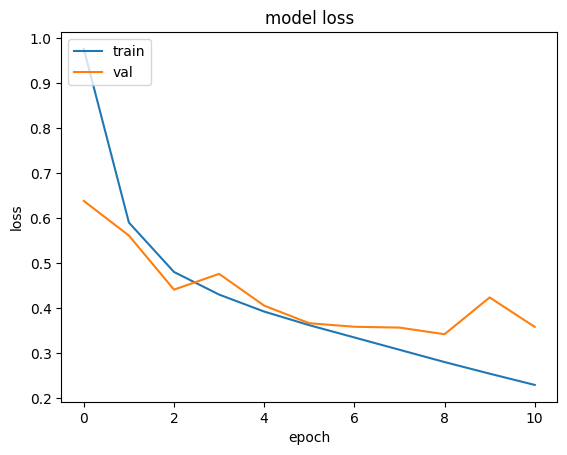

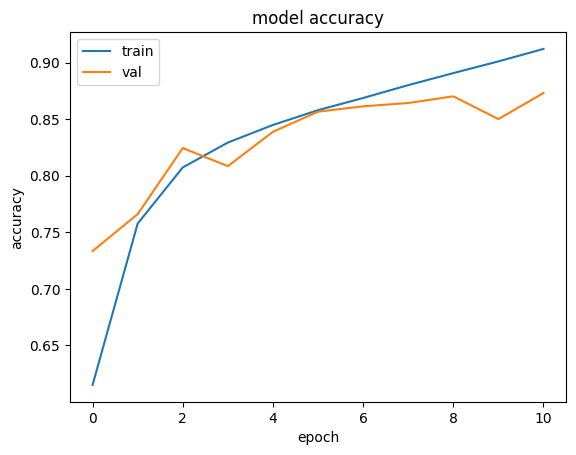

5443/5443 [==============================] - 160s 29ms/step - loss: 1.0135 - accuracy: 0.6877
5443/5443 - 143s - 143s/epoch - 26ms/step
Confusion matrix, without normalization
[[36481  3206  2217]
 [ 3432 13057  6317]
 [ 4580  7446 10345]]


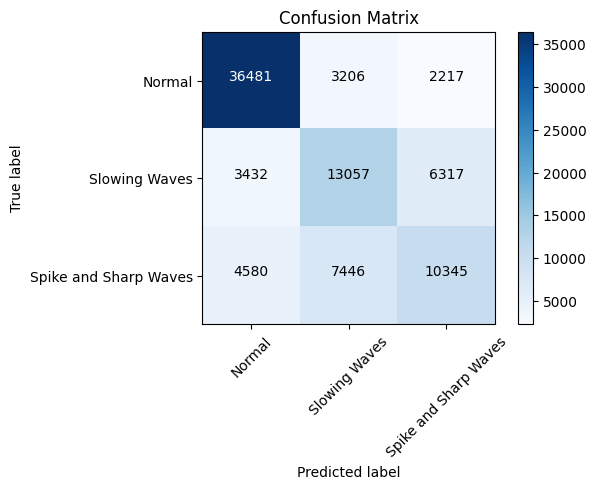

0.68767010025149
                       precision    recall  f1-score   support

               Normal    0.81993   0.87059   0.84450     41904
        Slowing Waves    0.55072   0.57252   0.56141     22806
Spike and Sharp Waves    0.54796   0.46243   0.50158     22371

             accuracy                        0.68767     87081
            macro avg    0.63954   0.63518   0.63583     87081
         weighted avg    0.67956   0.68767   0.68226     87081

Epoch 1/30
9596/9596 [==============================] - 572s 58ms/step - loss: 1.8492 - dense_4_loss: 0.6069 - dense_1_loss: 0.6338 - dense_3_loss: 0.6086 - dense_4_accuracy: 0.7408 - dense_1_accuracy: 0.7277 - dense_3_accuracy: 0.7404 - val_loss: 1.5087 - val_dense_4_loss: 0.4918 - val_dense_1_loss: 0.5236 - val_dense_3_loss: 0.4934 - val_dense_4_accuracy: 0.8021 - val_dense_1_accuracy: 0.7896 - val_dense_3_accuracy: 0.8021
Epoch 2/30
9596/9596 [==============================] - 562s 59ms/step - loss: 1.4617 - dense_4_loss: 0.4752 -

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


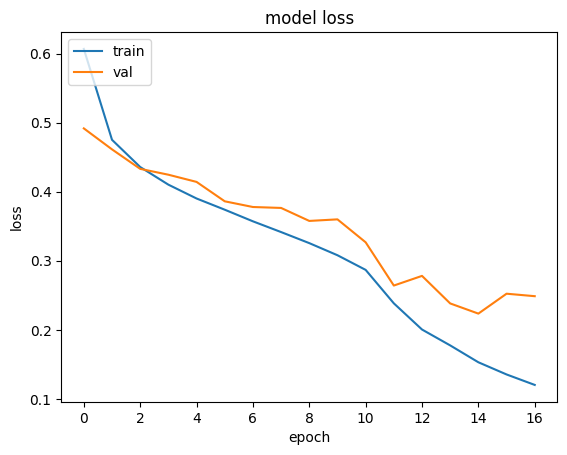

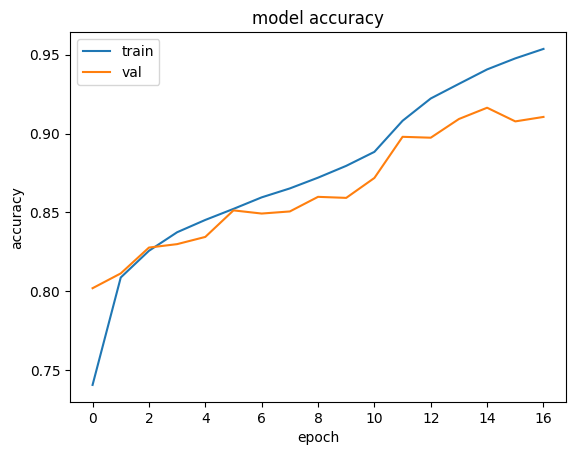

5443/5443 [==============================] - 238s 44ms/step - loss: 1.8135 - dense_4_loss: 0.7005 - dense_1_loss: 0.4903 - dense_3_loss: 0.6228 - dense_4_accuracy: 0.7797 - dense_1_accuracy: 0.7914 - dense_3_accuracy: 0.7819
5443/5443 - 175s - 175s/epoch - 32ms/step
Confusion matrix, without normalization
[[39561   923  1420]
 [  291 16465  6050]
 [ 2830  6647 12894]]


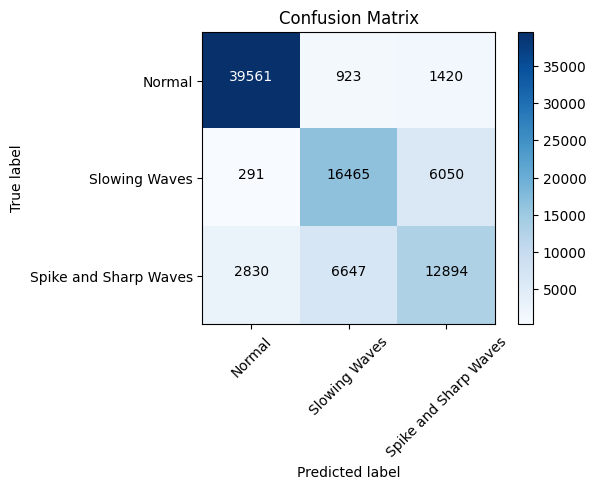

0.7914470435571479
                       precision    recall  f1-score   support

               Normal    0.92688   0.94409   0.93540     41904
        Slowing Waves    0.68504   0.72196   0.70302     22806
Spike and Sharp Waves    0.63318   0.57637   0.60344     22371

             accuracy                        0.79145     87081
            macro avg    0.74837   0.74747   0.74729     87081
         weighted avg    0.78809   0.79145   0.78926     87081

Epoch 1/30
9596/9596 [==============================] - 1267s 131ms/step - loss: 0.5278 - accuracy: 0.7829 - val_loss: 0.4336 - val_accuracy: 0.8275
Epoch 2/30
9596/9596 [==============================] - 1252s 130ms/step - loss: 0.4121 - accuracy: 0.8367 - val_loss: 0.3961 - val_accuracy: 0.8413
Epoch 3/30
9596/9596 [==============================] - 1242s 129ms/step - loss: 0.3717 - accuracy: 0.8530 - val_loss: 0.3865 - val_accuracy: 0.8461
Epoch 4/30
9596/9596 [==============================] - 1244s 130ms/step - loss: 0.3401 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


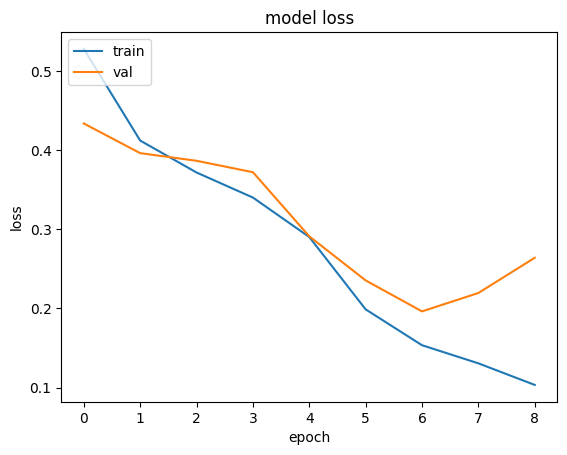

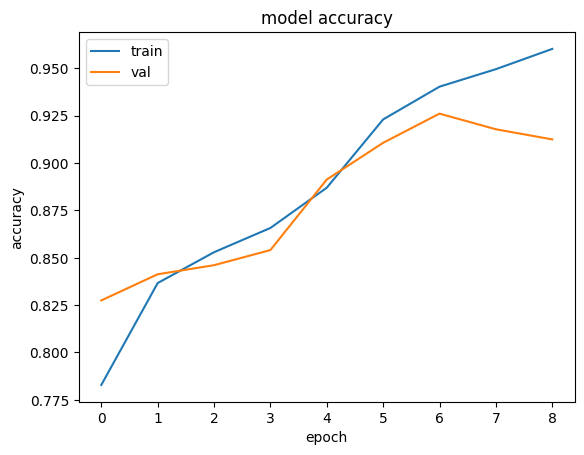

5443/5443 [==============================] - 124s 23ms/step - loss: 0.7572 - accuracy: 0.7712
5443/5443 - 117s - 117s/epoch - 21ms/step
Confusion matrix, without normalization
[[37412  1803  2689]
 [  112 18130  4564]
 [  835  9925 11611]]


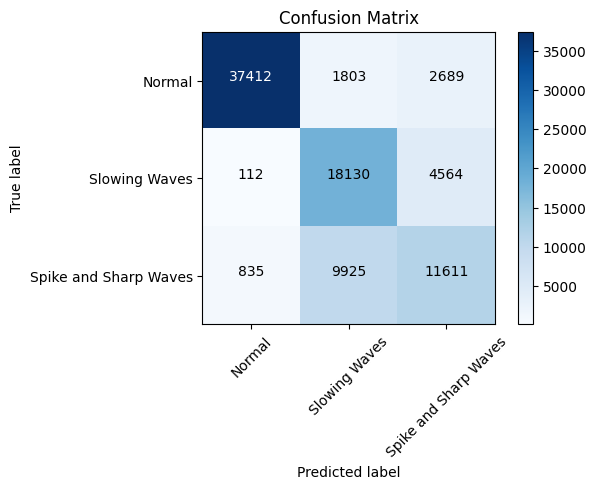

0.7711555907718102
                       precision    recall  f1-score   support

               Normal    0.97531   0.89280   0.93224     41904
        Slowing Waves    0.60721   0.79497   0.68852     22806
Spike and Sharp Waves    0.61551   0.51902   0.56316     22371

             accuracy                        0.77116     87081
            macro avg    0.73268   0.73560   0.72797     87081
         weighted avg    0.78648   0.77116   0.77359     87081

------------------- gaus1 -------------------------
Found 307075 images belonging to 3 classes.
Found 53430 images belonging to 3 classes.
Found 87059 images belonging to 3 classes.
Class Weights {0: 0.6868534362243471, 1: 1.0778532441776796, 2: 1.6225462999656548}


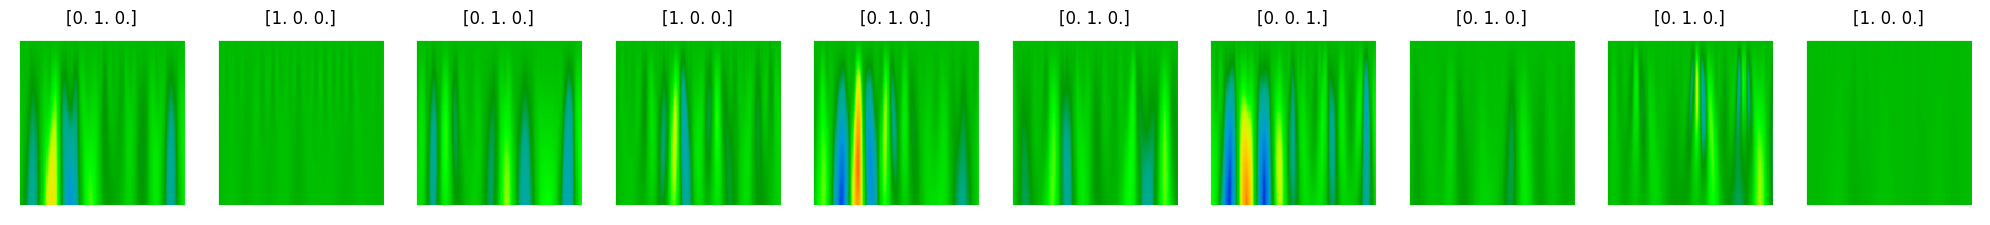

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-09 23:19:12.259495: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9597/9597 [==============================] - 1190s 122ms/step - loss: 0.8475 - accuracy: 0.6912 - val_loss: 0.5096 - val_accuracy: 0.7974
Epoch 2/30
9597/9597 [==============================] - 1280s 133ms/step - loss: 0.4931 - accuracy: 0.8085 - val_loss: 0.4593 - val_accuracy: 0.8232
Epoch 3/30
9597/9597 [==============================] - 1157s 121ms/step - loss: 0.4101 - accuracy: 0.8414 - val_loss: 0.4146 - val_accuracy: 0.8398
Epoch 4/30
9597/9597 [==============================] - 1145s 119ms/step - loss: 0.3635 - accuracy: 0.8597 - val_loss: 0.3344 - val_accuracy: 0.8691
Epoch 5/30
9597/9597 [==============================] - 1142s 119ms/step - loss: 0.3322 - accuracy: 0.8716 - val_loss: 0.3405 - val_accuracy: 0.8697
Epoch 6/30
9597/9597 [==============================] - 1144s 119ms/step - loss: 0.3070 - accuracy: 0.8807 - val_loss: 0.3206 - val_accuracy: 0.8738
Epoch 7/30
9597/9597 [==============================] - 1146s 119ms/step - loss: 0.2823 - accuracy: 0.8909 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


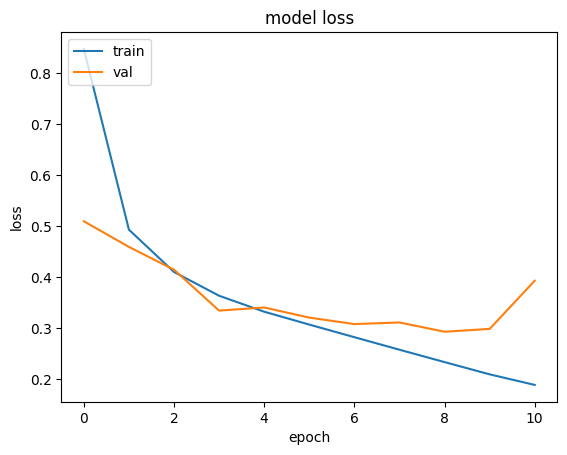

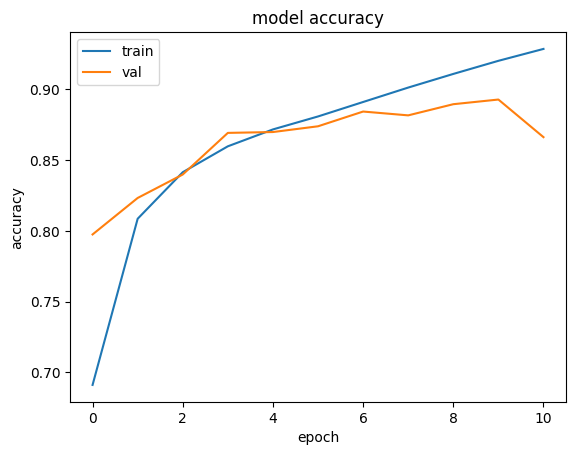

5442/5442 [==============================] - 94s 17ms/step - loss: 0.7974 - accuracy: 0.7497
5442/5442 - 76s - 76s/epoch - 14ms/step
Confusion matrix, without normalization
[[34128  3532  4222]
 [ 1023 18349  3434]
 [ 3207  6369 12795]]


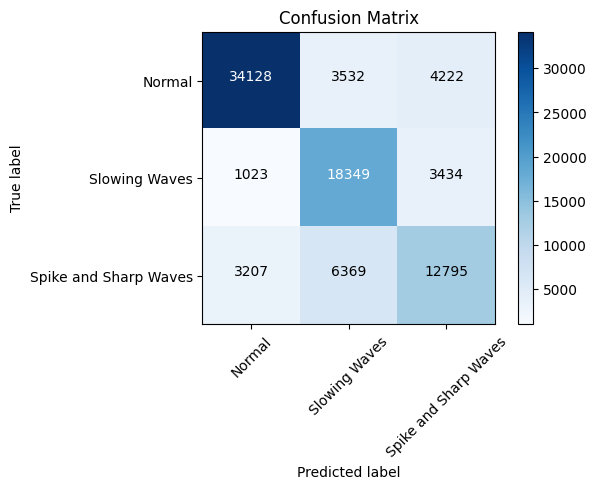

0.7497444261937307
                       precision    recall  f1-score   support

               Normal    0.88972   0.81486   0.85065     41882
        Slowing Waves    0.64952   0.80457   0.71878     22806
Spike and Sharp Waves    0.62564   0.57195   0.59759     22371

             accuracy                        0.74974     87059
            macro avg    0.72163   0.73046   0.72234     87059
         weighted avg    0.75894   0.74974   0.75108     87059

Epoch 1/30
9597/9597 [==============================] - 319s 32ms/step - loss: 1.6346 - dense_4_loss: 0.5302 - dense_1_loss: 0.5667 - dense_3_loss: 0.5377 - dense_4_accuracy: 0.7813 - dense_1_accuracy: 0.7601 - dense_3_accuracy: 0.7769 - val_loss: 1.3500 - val_dense_4_loss: 0.4368 - val_dense_1_loss: 0.4711 - val_dense_3_loss: 0.4421 - val_dense_4_accuracy: 0.8273 - val_dense_1_accuracy: 0.8120 - val_dense_3_accuracy: 0.8266
Epoch 2/30
9597/9597 [==============================] - 308s 32ms/step - loss: 1.3187 - dense_4_loss: 0.4257

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


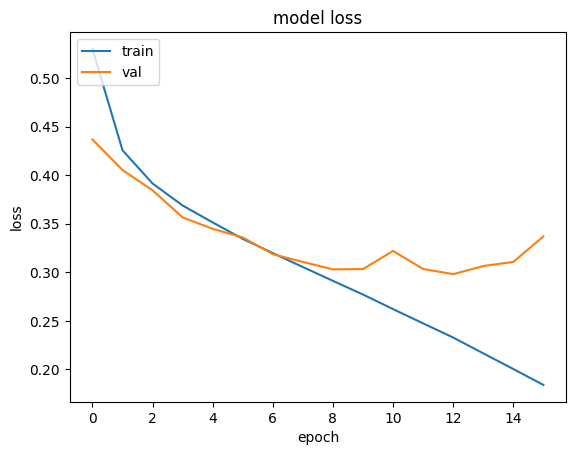

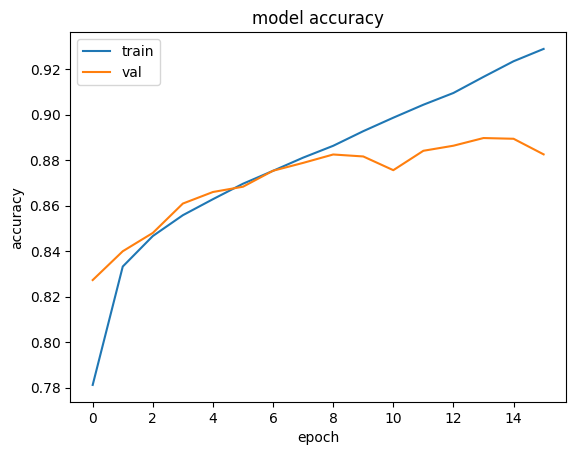

5442/5442 [==============================] - 54s 10ms/step - loss: 2.0803 - dense_4_loss: 0.8049 - dense_1_loss: 0.5870 - dense_3_loss: 0.6884 - dense_4_accuracy: 0.7524 - dense_1_accuracy: 0.7718 - dense_3_accuracy: 0.7626
5442/5442 - 54s - 54s/epoch - 10ms/step
Confusion matrix, without normalization
[[37548  2538  1796]
 [ 1571 18931  2304]
 [ 4441  7220 10710]]


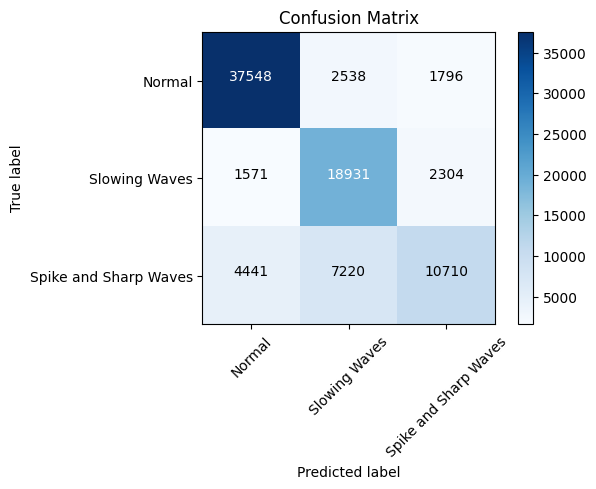

0.7717639761541024
                       precision    recall  f1-score   support

               Normal    0.86198   0.89652   0.87891     41882
        Slowing Waves    0.65987   0.83009   0.73526     22806
Spike and Sharp Waves    0.72316   0.47874   0.57610     22371

             accuracy                        0.77176     87059
            macro avg    0.74834   0.73512   0.73009     87059
         weighted avg    0.77337   0.77176   0.76347     87059

Epoch 1/30
9597/9597 [==============================] - 1123s 117ms/step - loss: 0.4613 - accuracy: 0.8168 - val_loss: 0.4109 - val_accuracy: 0.8383
Epoch 2/30
9597/9597 [==============================] - 1115s 116ms/step - loss: 0.3749 - accuracy: 0.8539 - val_loss: 0.3476 - val_accuracy: 0.8652
Epoch 3/30
9597/9597 [==============================] - 1113s 116ms/step - loss: 0.3443 - accuracy: 0.8659 - val_loss: 0.3290 - val_accuracy: 0.8706
Epoch 4/30
9597/9597 [==============================] - 1112s 116ms/step - loss: 0.3216 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


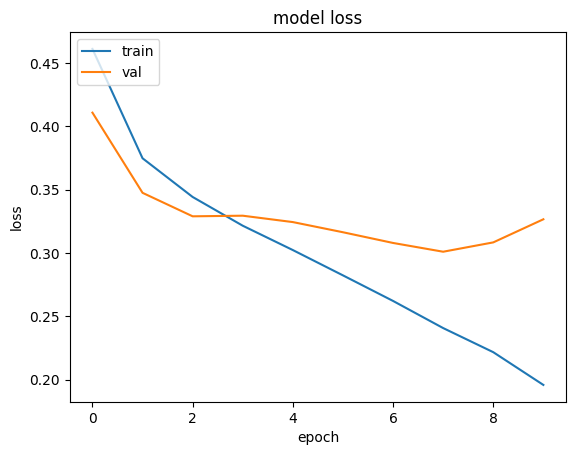

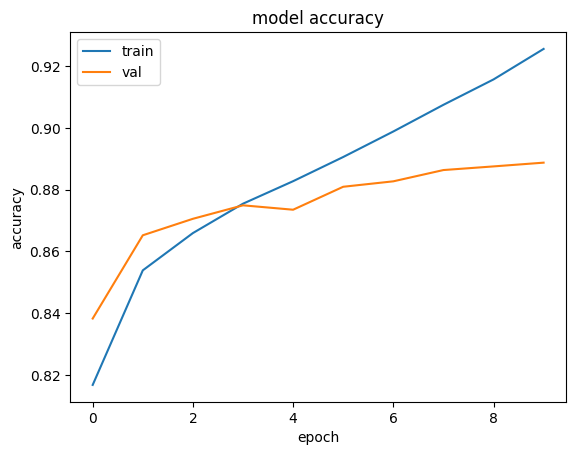

5442/5442 [==============================] - 125s 23ms/step - loss: 0.7764 - accuracy: 0.7582
5442/5442 - 117s - 117s/epoch - 22ms/step
Confusion matrix, without normalization
[[37459  2405  2018]
 [ 2449 16421  3936]
 [ 5262  4982 12127]]


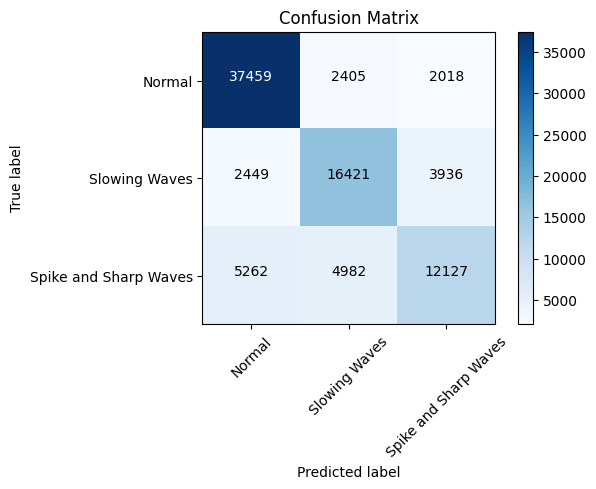

0.7581869766480203
                       precision    recall  f1-score   support

               Normal    0.82929   0.89439   0.86061     41882
        Slowing Waves    0.68973   0.72003   0.70455     22806
Spike and Sharp Waves    0.67070   0.54209   0.59957     22371

             accuracy                        0.75819     87059
            macro avg    0.72991   0.71884   0.72158     87059
         weighted avg    0.75198   0.75819   0.75265     87059

------------------- gaus2 -------------------------
Found 307032 images belonging to 3 classes.
Found 53413 images belonging to 3 classes.
Found 87064 images belonging to 3 classes.
Class Weights {0: 0.6869554711307406, 1: 1.077702311377876, 2: 1.6223190932868352}


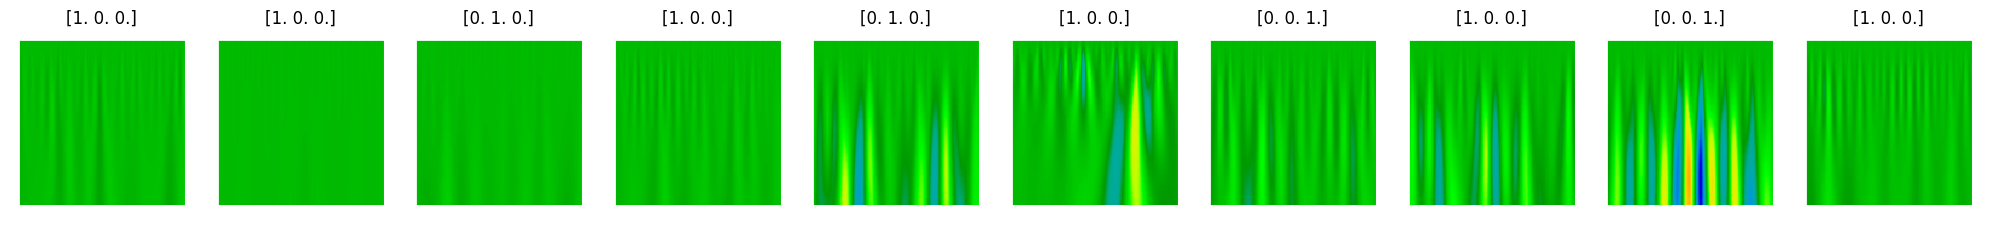

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-08-10 07:29:15.753148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9595/9595 [==============================] - 1170s 120ms/step - loss: 0.8534 - accuracy: 0.6920 - val_loss: 0.5257 - val_accuracy: 0.7796
Epoch 2/30
9595/9595 [==============================] - 1146s 119ms/step - loss: 0.5049 - accuracy: 0.8019 - val_loss: 0.4242 - val_accuracy: 0.8319
Epoch 3/30
9595/9595 [==============================] - 1149s 120ms/step - loss: 0.4212 - accuracy: 0.8362 - val_loss: 0.4066 - val_accuracy: 0.8397
Epoch 4/30
9595/9595 [==============================] - 1148s 120ms/step - loss: 0.3750 - accuracy: 0.8548 - val_loss: 0.3702 - val_accuracy: 0.8557
Epoch 5/30
9595/9595 [==============================] - 1146s 119ms/step - loss: 0.3417 - accuracy: 0.8677 - val_loss: 0.3419 - val_accuracy: 0.8661
Epoch 6/30
9595/9595 [==============================] - 1146s 119ms/step - loss: 0.3145 - accuracy: 0.8781 - val_loss: 0.3319 - val_accuracy: 0.8736
Epoch 7/30
9595/9595 [==============================] - 1146s 119ms/step - loss: 0.2888 - accuracy: 0.8884 - val_loss

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


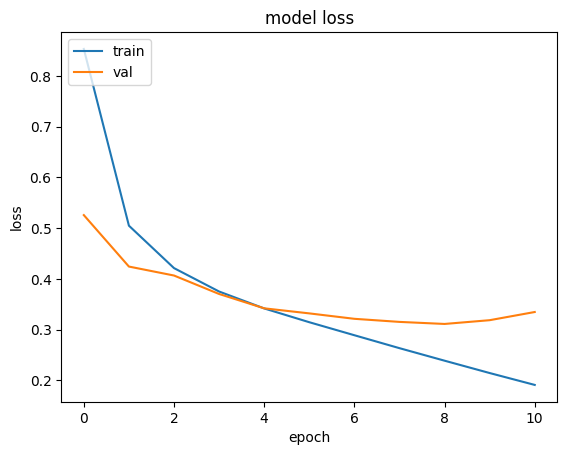

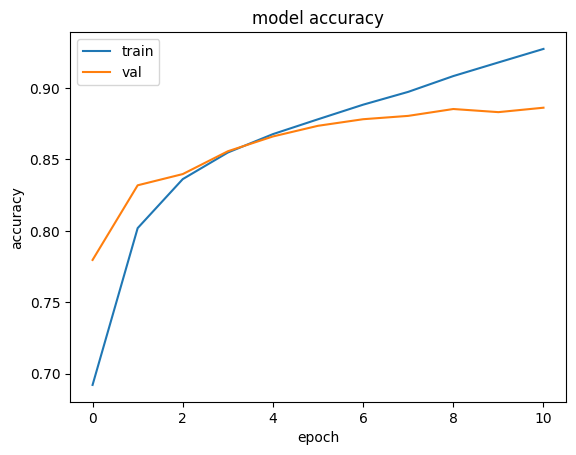

5442/5442 [==============================] - 86s 16ms/step - loss: 0.9185 - accuracy: 0.7399
5442/5442 - 76s - 76s/epoch - 14ms/step
Confusion matrix, without normalization
[[36752  2810  2325]
 [ 2015 17590  3201]
 [ 5028  7267 10076]]


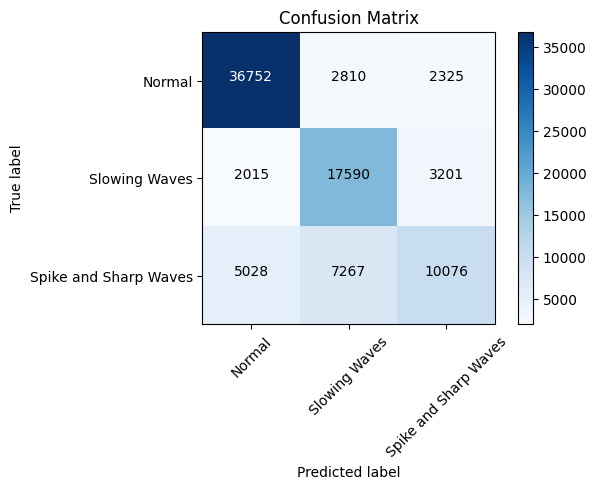

0.7398924928788018
                       precision    recall  f1-score   support

               Normal    0.83918   0.87741   0.85787     41887
        Slowing Waves    0.63578   0.77129   0.69701     22806
Spike and Sharp Waves    0.64581   0.45040   0.53069     22371

             accuracy                        0.73989     87064
            macro avg    0.70692   0.69970   0.69519     87064
         weighted avg    0.73622   0.73989   0.73166     87064

Epoch 1/30
9595/9595 [==============================] - 321s 33ms/step - loss: 1.6073 - dense_4_loss: 0.5241 - dense_1_loss: 0.5546 - dense_3_loss: 0.5286 - dense_4_accuracy: 0.7849 - dense_1_accuracy: 0.7686 - dense_3_accuracy: 0.7825 - val_loss: 1.3466 - val_dense_4_loss: 0.4434 - val_dense_1_loss: 0.4587 - val_dense_3_loss: 0.4446 - val_dense_4_accuracy: 0.8285 - val_dense_1_accuracy: 0.8179 - val_dense_3_accuracy: 0.8272
Epoch 2/30
9595/9595 [==============================] - 308s 32ms/step - loss: 1.2916 - dense_4_loss: 0.4193

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


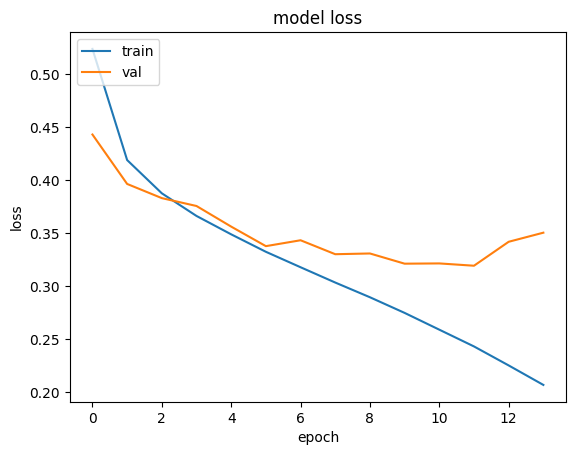

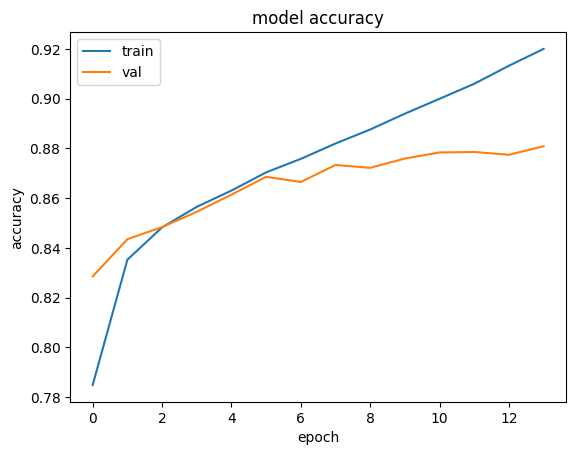

5442/5442 [==============================] - 56s 10ms/step - loss: 2.1666 - dense_4_loss: 0.8065 - dense_1_loss: 0.6106 - dense_3_loss: 0.7495 - dense_4_accuracy: 0.7509 - dense_1_accuracy: 0.7701 - dense_3_accuracy: 0.7510
5442/5442 - 54s - 54s/epoch - 10ms/step
Confusion matrix, without normalization
[[37334  2324  2229]
 [ 2084 16693  4029]
 [ 5003  4348 13020]]


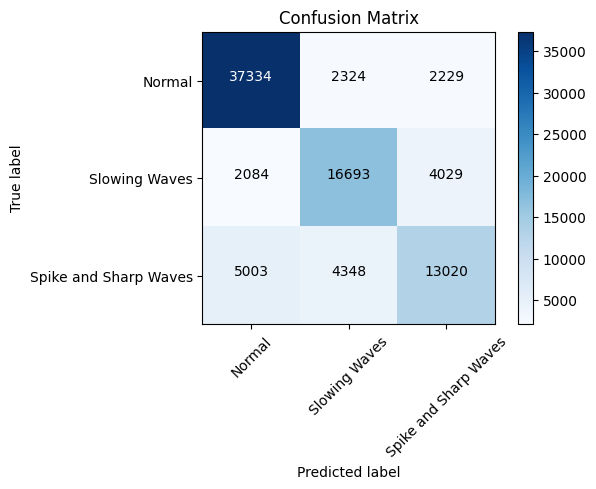

0.7700886704033815
                       precision    recall  f1-score   support

               Normal    0.84046   0.89130   0.86513     41887
        Slowing Waves    0.71444   0.73196   0.72309     22806
Spike and Sharp Waves    0.67538   0.58200   0.62523     22371

             accuracy                        0.77009     87064
            macro avg    0.74343   0.73509   0.73782     87064
         weighted avg    0.76503   0.77009   0.76628     87064

Epoch 1/30
9595/9595 [==============================] - 1130s 118ms/step - loss: 0.4552 - accuracy: 0.8199 - val_loss: 0.4016 - val_accuracy: 0.8440
Epoch 2/30
9595/9595 [==============================] - 1115s 116ms/step - loss: 0.3679 - accuracy: 0.8564 - val_loss: 0.3639 - val_accuracy: 0.8596
Epoch 3/30
9595/9595 [==============================] - 1113s 116ms/step - loss: 0.3359 - accuracy: 0.8695 - val_loss: 0.3507 - val_accuracy: 0.8638
Epoch 4/30
9595/9595 [==============================] - 1113s 116ms/step - loss: 0.3110 - 

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


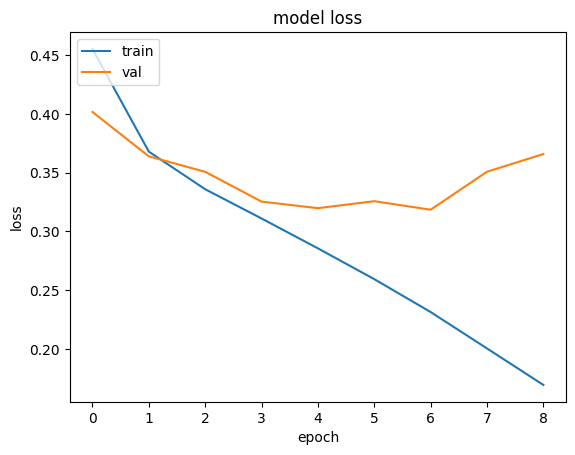

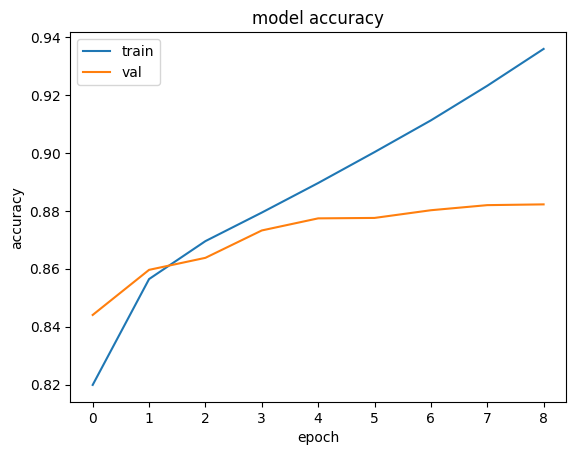

5442/5442 [==============================] - 125s 23ms/step - loss: 0.9702 - accuracy: 0.7328
5442/5442 - 117s - 117s/epoch - 22ms/step
Confusion matrix, without normalization
[[37190  2714  1983]
 [ 4061 15417  3328]
 [ 4495  6680 11196]]


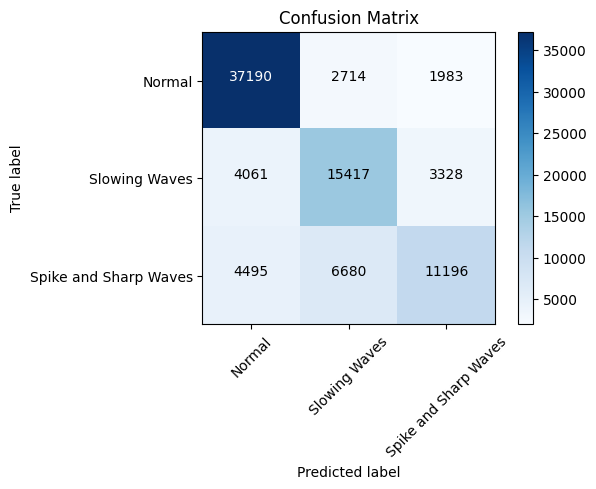

0.7328287236975098
                       precision    recall  f1-score   support

               Normal    0.81297   0.88786   0.84877     41887
        Slowing Waves    0.62138   0.67601   0.64754     22806
Spike and Sharp Waves    0.67826   0.50047   0.57596     22371

             accuracy                        0.73283     87064
            macro avg    0.70420   0.68811   0.69075     87064
         weighted avg    0.72817   0.73283   0.72596     87064



In [12]:
for waveletsType in waveletsTypes:
    
    print("-------------------",waveletsType,"-------------------------")
    checkpoint_filepath = '/home/dll-1/Desktop/eeg/datasets/models/adil/deeplearning/'+waveletsType

    train_path = main_directory +'/'+waveletsType+'/train' + '/'
    valid_path = main_directory +'/'+waveletsType+'/valid' + '/'
    test_path = main_directory +'/'+waveletsType+'/test' + '/'

    train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 32, shuffle = True)
    valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 16)
    test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), interpolation = 'nearest',classes = class_labels, batch_size = 16, shuffle = False)

    # Class Weigths
    labels = train_batches.classes
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    class_weights = dict(enumerate(class_weights))
    print('Class Weights',class_weights)
    
    assert valid_batches.n > 0
    assert test_batches.n > 0
    assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

    imgs, train_labels = next(train_batches)
    plotImages(imgs,train_labels) 

    ##### VGG16

    ###### Import and Build Model

    vgg16_model = keras.applications.vgg16.VGG16()

    effNet_model_custom = tf.keras.applications.EfficientNetB1(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=3,classifier_activation='softmax')

    vgg16_model_custom = Sequential()
    for layer in vgg16_model.layers[:-1]:
        vgg16_model_custom.add(layer)

    # for layer in model.layers:
    #     layer.trainable = False

    vgg16_model_custom.add(Dense(3, activation = 'softmax'))

    vgg16_model_custom.summary()
    vgg16_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    effNet_model_custom.summary()
    effNet_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    google_lenet = GoogLeNet()

    # google_lenet.summary()
    google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

    effNet_model_custom = evaluate_effNet(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(effNet_model_custom, test_batches,"effNet")

    google_lenet_model = evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath,class_weights)
    test_model(google_lenet,test_batches,"googlenet")
    
    vgg16_model_custom = evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(vgg16_model_custom, test_batches,"vgg16")

    

    


    